# Fitting Radial Velocity Data
This example shows how to fit a dynamical model of a star and two planets to a set of radial velocity observations using the N-body integrator REBOUND and MCMC sampler emcee.

First, let's import the REBOUND, emcee, numpy, corner, and matplotlib packages.

In [1448]:
! pip install rebound
! pip install emcee
! pip install corner
import rebound
import emcee
import corner
import numpy as np
import matplotlib.pyplot as plt

We start by creating some artifical radial velocity data. Naturally, we also use REBOUND for this.

In [1450]:
sim = rebound.Simulation()
sim.units = ["msun", "m", "s"] # Units of solar mass, meters, and seconds

We add a star and two Jupiter mass planets on 21 and 30 day orbits. The inner planet has an eccentricity of 0.1 (here expressed in terms of h and k variables).

In [1452]:
mstar =1
sim.add(m=mstar) #star
sim.add(m=1e-3, P=100*60*60*24, h=0.05, k=0.01) #Planet 1
sim.add(m=1e-3, P=10*60*60*24, h=0.05, k=0.01) #Planet 2
sim.move_to_com()

We simulate 30 randomly spaced observations over a 50 day interval and add some noise along the way. We assume the line of sight is along the x direction. 

In [1454]:
N     = 90
error = 30
noise = 20

times = np.sort(50*60*60*24*np.random.random(N)) # 30 randomly spaced observations
RVs = np.zeros(N)
for i, t in enumerate(times):
    sim.integrate(times[i])
    RVs[i] = sim.particles[0].vx # radial velocity of the host star
RVs += np.random.normal(size=N, scale=noise) # add 20m/s Gaussian noise

This is how our artificial dataset looks like:

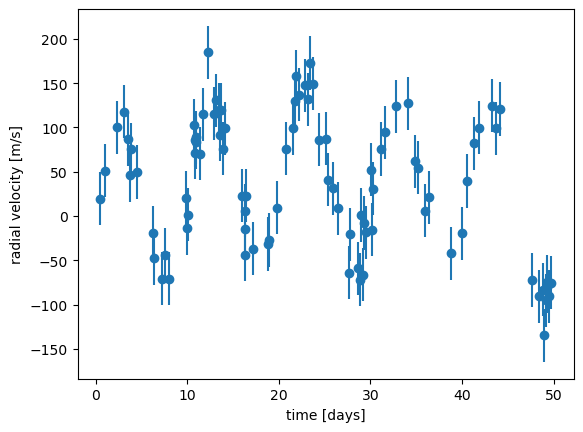

In [1456]:
fig, ax = plt.subplots(1,1)
ax.set_xlabel("time [days]")
ax.set_ylabel("radial velocity [m/s]")
ax.errorbar(times/(24*60*60), RVs, yerr=error, fmt="o");

Next, we create a likelihood function. For simplicity, we assume a flat prior for all parameters. So effectively, our MCMC will sample the likelihood function and we will interpret this as our posterior. As part of an actual data reduction pipeline, you will probably have a more complicated model with physically motivated priors. At the very least, you should add some basic sanity checks to your prior. For example, the mass should never become negative. 

To further simplify things a little, we restrict the planetary system to always be in the x-y plane. This means we have 5 free parameters per planet, 2 positions, 2 velocities, and 1 mass. We will run the MCMC in a coordinate system where we use the period $P$, the orbital phase in terms of the mean longitude $l$, and $h$ and $k$. We use $h$ and $k$ instead of the eccentricity and the argument of periastron to avoid a coordinate singularity in the case of $e=0$. We consider the mass of the host star as fixed.

In [1458]:
def setup_sim(params):
    P1, P2, l1, l2, h1, h2, k1, k2, m1, m2 = params # unpack
    #P1, l1, h1, k1, m1 = params # unpack
    sim = rebound.Simulation()
    sim.units = ["msun", "m", "s"]
    sim.add(m=mstar)
    sim.add(m=m1, P=P1*60*60*24, h=h1, k=k1, l=l1)  #First planet
    sim.add(m=m2, P=P2*60*60*24, h=h2, k=k2, l=l2)  #Second planet
    sim.move_to_com()
    return sim
def log_likelihood(params, times, RVs):
    ll = 0. # We use the log likelihood to avoid numerical issues with very small/large numbers
    sigma = error # We assume the error bars are 30 m/s for all observations
    sim = setup_sim(params)
    for i, t in enumerate(times):
        sim.integrate(times[i])
        deltaRV = sim.particles[0].vx - RVs[i]
        ll += -(deltaRV/sigma)**2
    return ll

Next, we need to come up with some reasonable initial conditions. The closer we start to the correct solution, the faster the MCMC will converge. For this example, we'll start very close. Note that we should in principle also allow other parameters to vary. For example, the noise should be modelled self-consistently, rather than assuming Gaussian noise with a given strength. We should also allow for an arbitrary offset to the radial velocity in case the system is moving towards or away from us. We might also want to allow for a linear term in the radial velocity that can account for yet undetected perturbers further out.

In [1460]:
#For one planet
#ndim, nwalkers = 5*1, 20
#P1, l1, h1, k1, m1
#ic = [567.0, 0.01, 0.01, 0.01, 1e-4]

#For two planets
ndim, nwalkers = 5*2, 20
# P1, P2, l1, l2, h1, h2, k1, k2, m1, m2
ic = [100.0, 10.0, 0.01, 0.01, 0.05, 0.05, 0.01, 0.01, 1e-3, 1e-3] 

ic = np.tile(ic,(nwalkers,1)) # copy initial conditions for each walker
ic += 0.05*np.random.random((nwalkers,ndim))*ic # slightly perturb initial conditions

Now we can finally run the MCMC for 500 iterations. We have 20 walkers, so this will generate 10000 samples. This may take a minute or two.

In [1462]:
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_likelihood, args=[times, RVs])
state = sampler.run_mcmc(ic, 500)

ValueError: Probability function returned NaN

Let us check the convergence of the MCMC by plotting the log probability. 

In [ ]:
fig, ax = plt.subplots(1,1)
ax.set_xlabel("iterations")
ax.set_ylabel("log probability")
ax.plot(sampler.flatlnprobability);

This plots gives us some convidence that we have converged. Let's make a corner plot, comparing the posterior samples to the true values which we used to setup our test system. We cut out the first quarter of the MCMC (the burn-in phase).

In [ ]:
corner.corner(sampler.flatchain[2500:],
              #For two planets
              labels = ["P1","P2","l1","l2","h1","h2","k1","k2","m1","m2"], 
              truths = [100,10,0,0,0.5,0.05,0.01,0.01,1e-3,1e-3]);

              #For one planet
              #labels = ["P1","l1","h1","k1","m1"], 
              #truths = [21,0,0.1,0,1e-3]);

That's a pretty good recovery of the correct parameters (but to be fair, we started pretty close to them). Let's draw a few random samples from the posterior and plot the corresponding RV curves so we can compare our model to our data.

In [ ]:
fig, ax = plt.subplots(1,1)
ax.set_xlabel("time [days]")
ax.set_ylabel("radial velocity [m/s]")

times_plot = np.linspace(0,times[-1],1000)
RVs_plot = np.zeros(len(times_plot))
Nplot = 20
indx = np.random.choice(7500, Nplot, replace=False)
for i in range(Nplot):
    s = setup_sim(sampler.flatchain[2500+indx[i]]) # skipping burn-in
    for j, t in enumerate(times_plot):
        s.integrate(t)
        RVs_plot[j] = s.particles[0].vx
    ax.plot(times_plot/(24*60*60), RVs_plot, color="black", alpha=0.13)
    
ax.errorbar(times/(24*60*60), RVs, yerr=error, fmt="o");    
    